In [90]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from keras import Input, layers, Model, models
from keras.applications import *
from keras.callbacks import EarlyStopping
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img
import keras_tuner as kt

from sklearn.metrics import confusion_matrix, classification_report, f1_score, top_k_accuracy_score
from sklearn.model_selection import train_test_split

%matplotlib inline

### Dataset

In [2]:
DATA_DIR_NAME = 'data'

In [3]:
class_names = os.listdir(DATA_DIR_NAME)
class_names.sort()
num_classes = len(class_names)
class_names[:10]

['Abra',
 'Aerodactyl',
 'Alakazam',
 'Arbok',
 'Arcanine',
 'Articuno',
 'Beedrill',
 'Bellsprout',
 'Blastoise',
 'Bulbasaur']

In [4]:
image_paths = []
labels = []
for class_name in class_names:
    pokemon_dir = os.path.join(DATA_DIR_NAME, class_name)
    image_file_names = os.listdir(pokemon_dir)
    image_paths.extend(os.path.join(pokemon_dir, name) for name in image_file_names)
    labels.extend([class_name] * len(image_file_names))

df = pd.DataFrame({'filename': image_paths, 'class': labels})

In [5]:
df.value_counts('class')

class
Pikachu      286
Charizard    167
Venusaur     162
Sandslash    142
Gengar       140
            ... 
Poliwrath     61
Nidoking      60
Dratini       57
Nidoran♂      50
Nidoran♀      44
Name: count, Length: 151, dtype: int64

In [6]:
# 60:20:20 train-validation-test split
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    shuffle=True,
    stratify=df['class']  # Ensure all pokemon represented in each split
)
train_df, validation_df = train_test_split(
    train_df,
    test_size=0.25,
    random_state=42,
    shuffle=True,
    stratify=train_df['class']
)

In [200]:
# Display images in a grid format
def display_images(image_paths, captions, image_size, cols, figsize=(8, 8)):
    rows = (len(image_paths) + cols - 1) // cols
    fig, axs = plt.subplots(rows, cols, figsize=figsize)
    axs = axs.ravel()
    for ax in axs:
        ax.axis('off')
    for ax, image_path, caption in zip(axs, image_paths, captions):
        image = load_img(image_path, target_size=image_size)
        ax.set_title(caption)
        ax.imshow(image)

    plt.show()

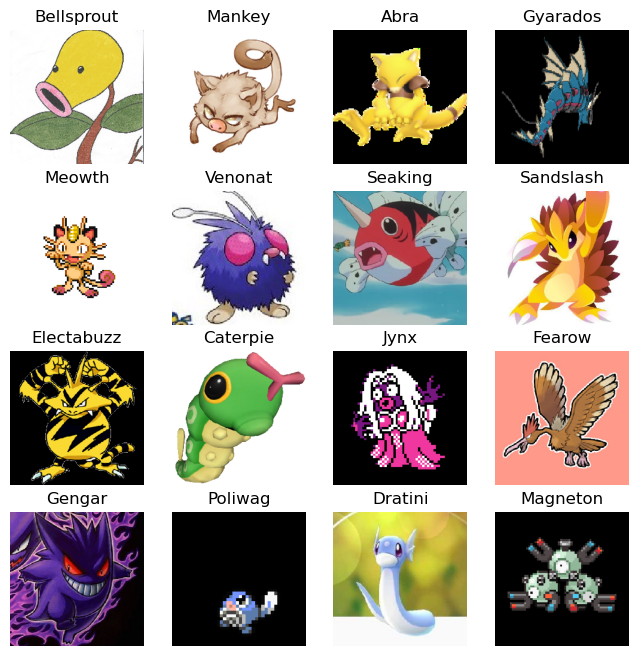

In [201]:
sample_images = train_df[:16]
display_images(sample_images['filename'], sample_images['class'], (224, 224), 4)

### Utilities

In [40]:
def make_image_generator(dataframe, image_size, preprocessing_function, batch_size=64, shuffle=True, **augmentations):
    datagen = ImageDataGenerator(
        preprocessing_function=preprocessing_function,
        **augmentations
    )
    return datagen.flow_from_dataframe(
        dataframe,
        target_size=image_size,
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=shuffle
    )

In [8]:
def make_training_generators(image_size, preprocessing_function, batch_size=64, **augmentations):
    train_generator = make_image_generator(train_df, image_size, preprocessing_function, batch_size, **augmentations)
    validation_generator = make_image_generator(validation_df, image_size, preprocessing_function, batch_size)
    return train_generator, validation_generator

In [9]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=1,
    restore_best_weights=True
)

### Baseline Model

In [ ]:
train_generator, validation_generator = make_training_generators(
    image_size=(224, 224),
    preprocessing_function=vgg16.preprocess_input
)

In [ ]:
vgg16_base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg16_base_model.trainable = False

vgg16_model = models.Sequential([
    vgg16_base_model,
    layers.Flatten(input_shape=vgg16_base_model.output_shape[1:]),
    layers.Dense(4096, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

vgg16_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
vgg16_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    callbacks=[early_stopping]
)

In [ ]:
vgg16_model.save('models/model_baseline.tf')

### Models

In [ ]:
train_generator, validation_generator = make_training_generators(
    image_size=(224, 224),
    preprocessing_function=resnet.preprocess_input
)

resnet_base_model = ResNet152(weights='imagenet', include_top=False)
resnet_base_model.trainable = False

resnet_model = models.Sequential([
    resnet_base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(num_classes, activation='softmax')
])

resnet_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
resnet_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[early_stopping]
)

In [ ]:
train_generator, validation_generator = make_training_generators(
    image_size=(299, 299),
    preprocessing_function=inception_v3.preprocess_input
)

inception_v3_base_model = InceptionV3(weights='imagenet', include_top=False)
inception_v3_base_model.trainable = False

inception_v3_model = models.Sequential([
    inception_v3_base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(num_classes, activation='softmax')
])

inception_v3_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
inception_v3_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[early_stopping]
)

In [ ]:
train_generator, validation_generator = make_training_generators(
    image_size=(299, 299),
    preprocessing_function=inception_resnet_v2.preprocess_input
)

inception_resnet_base_model = InceptionResNetV2(weights='imagenet', include_top=False)
inception_resnet_base_model.trainable = False

inception_resnet_model = models.Sequential([
    inception_resnet_base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(num_classes, activation='softmax')
])

inception_resnet_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
inception_resnet_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[early_stopping]
)

In [21]:
train_generator, validation_generator = make_training_generators(
    image_size=(224, 224),
    preprocessing_function=densenet.preprocess_input
)

densenet_base_model = DenseNet201(weights='imagenet', include_top=False)
densenet_base_model.trainable = False

densenet_model = models.Sequential([
    densenet_base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(num_classes, activation='softmax')
])

densenet_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

Found 8379 validated image filenames belonging to 151 classes.
Found 2793 validated image filenames belonging to 151 classes.


In [ ]:
densenet_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[early_stopping]
)

In [ ]:
train_generator, validation_generator = make_training_generators(
    image_size=(224, 224),
    preprocessing_function=efficientnet.preprocess_input
)

efficientnet_base_model = EfficientNetB7(weights='imagenet', include_top=False)
efficientnet_base_model.trainable = False

efficientnet_model = models.Sequential([
    efficientnet_base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(num_classes, activation='softmax')
])

efficientnet_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
efficientnet_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[early_stopping]
)

### Data Augmentation

In [10]:
# Without data augmentations
train_generator, validation_generator = make_training_generators(
    image_size=(224, 224),
    preprocessing_function=densenet.preprocess_input
)

densenet_base_model = DenseNet201(weights='imagenet', include_top=False)
densenet_base_model.trainable = False

densenet_model = models.Sequential([
    densenet_base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(num_classes, activation='softmax')
])

densenet_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

Found 8379 validated image filenames belonging to 151 classes.
Found 2793 validated image filenames belonging to 151 classes.


In [ ]:
hist1 = densenet_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[early_stopping]
)

In [30]:
train_size = len(train_generator) * 64
epochs = 20

In [ ]:
def make_augmented_dataset():
    return make_training_generators(
        image_size=(224, 224),
        preprocessing_function=densenet.preprocess_input,
        brightness_range = (0.8, 1.2),
        rotation_range=20,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )

In [22]:
# With data augmentations
train_generator, validation_generator = make_augmented_dataset()

densenet_base_model = DenseNet201(weights='imagenet', include_top=False)
densenet_base_model.trainable = False

densenet_model = models.Sequential([
    densenet_base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(num_classes, activation='softmax')
])

densenet_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

Found 8379 validated image filenames belonging to 151 classes.
Found 2793 validated image filenames belonging to 151 classes.


In [23]:
hist2 = densenet_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    callbacks=[early_stopping],
    steps_per_epoch=train_size / 64
)

Epoch 1/20
 76/130 [================>.............] - ETA: 4:55 - loss: 4.5225 - accuracy: 0.1099

KeyboardInterrupt: 

In [ ]:
plt.figure()
plt.plot(hist1.history['loss'], label='Training Loss (Without Data Augmentation)', color='blue')
plt.plot(hist1.history['val_loss'], label='Validation Loss (Without Data Augmentation)', color='cyan')
plt.plot(hist2.history['loss'], label='Training Loss (With Data Augmentation)', color='red')
plt.plot(hist2.history['val_loss'], label='Validation Loss (With Data Augmentation)', color='pink')

plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Hyperparameter Tuning for Classification Head

In [ ]:
train_generator, validation_generator = make_augmented_dataset()
densenet_base_model = DenseNet201(weights='imagenet', include_top=False)
densenet_base_model.trainable = False

In [ ]:
def build_model(hp):
    dropout = hp.Choice('dropout', values=[0.0, 0.2, 0.4])
    model = models.Sequential()
    model.add(densenet_base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(dropout))
    for i in range(hp.Int('num_layers', 0, 2)):
        model.add(layers.Dense(1024 // (2 ** i), activation='relu'))
        model.add(layers.Dropout(dropout))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(
        optimizer="adam",
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
#### HYPERPARAMETER TUNING #####
tuner = kt.tuners.GridSearch(
    build_model,
    objective='val_loss',
    directory='tuner',
    project_name='pokedex'
)

tuner.search_space_summary()

tuner.search(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[early_stopping]
)

tuner.results_summary()

### Training and Fine-tuning Final Model

In [ ]:
train_generator, validation_generator = make_augmented_dataset()

densenet_base_model = DenseNet201(weights='imagenet', include_top=False)
densenet_base_model.trainable = False
inputs = Input(shape=(224, 224, 3))
x = densenet_base_model(inputs, training=False)  # Ensure batchnorm layers run in inference mode
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history_train = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=[early_stopping]
)

In [ ]:
model.save('models/model_untuned.tf')
with open('histories/model_training.pkl', 'wb') as file:
    pickle.dump(history_train.history, file)

In [ ]:
NUM_LAYERS_TO_UNFREEZE = 50

for layer in densenet_base_model.layers[-NUM_LAYERS_TO_UNFREEZE:]:
    layer.trainable = True

model.compile(
    loss='categorical_crossentropy',
    optimizer=RMSprop(learning_rate=1e-5),
    metrics=['accuracy']
)

history_fine = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[early_stopping]
)

In [ ]:
model.save('models/model_final.tf')
with open('histories/model_tuning.pkl', 'wb') as file:
    pickle.dump(history_fine.history, file)

### Testing

In [11]:
baseline_model = models.load_model('models/model_baseline.tf')
final_model = models.load_model('models/model_final.tf')

In [60]:
baseline_model_test_generator = make_image_generator(
    test_df,
    image_size=(224, 224),
    preprocessing_function=vgg16.preprocess_input,
    shuffle=False
)
final_model_test_generator = make_image_generator(
    test_df,
    image_size=(224, 224),
    preprocessing_function=densenet.preprocess_input,
    shuffle=False
)

Found 2793 validated image filenames belonging to 151 classes.
Found 2793 validated image filenames belonging to 151 classes.


In [61]:
baseline_model_loss, baseline_model_acc = baseline_model.evaluate(baseline_model_test_generator)
final_model_loss, final_model_acc = final_model.evaluate(final_model_test_generator)

print(f'Baseline model loss:{baseline_model_loss:.5f}, Baseline model accuracy: {100 * baseline_model_acc:.3f}%')
print(f'Final model loss: {final_model_loss:.5f}, Final model accuracy: {100 * final_model_acc:.3f}%')

Final model loss: 0.35790, Final model accuracy: 93.054%


In [84]:
baseline_model_probs = baseline_model.predict(baseline_model_test_generator)
final_model_probs = final_model.predict(final_model_test_generator)
actual_labels = final_model_test_generator.classes

k = 3
baseline_model_k_acc = top_k_accuracy_score(actual_labels, baseline_model_probs, k=k)
final_model_k_acc = top_k_accuracy_score(actual_labels, final_model_probs, k=k)

print(f'Baseline model top-{k} accuracy: {100 * baseline_model_k_acc:.3f}%')
print(f'Final model top-{k} accuracy: {100 * final_model_k_acc:.3f}%')

Final model top-3 accuracy: 96.849%


In [78]:
baseline_pred_labels = np.argmax(baseline_model_probs, axis=-1)
final_pred_labels = np.argmax(final_model_probs, axis=-1)

# Use weighted average to account for class imbalance
baseline_model_f1 = f1_score(actual_labels, baseline_pred_labels, average='weighted')
final_model_f1 = f1_score(actual_labels, final_pred_labels, average='weighted')

print(f'Baseline model weighted average f1 score: {baseline_model_f1:.5f}')
print(f'Final model weighted average f1 score: {final_model_f1:.5f}')

Final model f1 score: 0.9306679081426001


In [73]:
print(classification_report(actual_labels, final_pred_labels, target_names=class_names))

              precision    recall  f1-score   support

        Abra       0.76      0.93      0.84        14
  Aerodactyl       0.94      0.85      0.89        20
    Alakazam       0.88      0.83      0.86        18
       Arbok       1.00      0.94      0.97        18
    Arcanine       0.80      0.84      0.82        19
    Articuno       0.90      0.95      0.92        19
    Beedrill       1.00      0.94      0.97        18
  Bellsprout       0.88      1.00      0.93        14
   Blastoise       0.96      0.96      0.96        27
   Bulbasaur       1.00      1.00      1.00        23
  Butterfree       1.00      0.95      0.98        22
    Caterpie       1.00      0.83      0.91        18
     Chansey       0.94      0.89      0.92        19
   Charizard       0.86      0.94      0.90        33
  Charmander       1.00      1.00      1.00        24
  Charmeleon       0.95      0.90      0.93        21
    Clefable       0.94      0.94      0.94        18
    Clefairy       0.89    

In [ ]:
conf_matrix = confusion_matrix(actual_labels, final_pred_labels)
sns.heatmap(conf_matrix, cmap='Blues')
plt.show()

In [70]:
most_common_misclassifications = []

for r, row in enumerate(conf_matrix):
    for c, val in enumerate(row):
        if r != c and val > 0:
            most_common_misclassifications.append((val, r, c))

most_common_misclassifications.sort(reverse=True)

print("Top Misclassifications:")
for count, actual, pred in most_common_misclassifications[:20]:
    print(f"True class {class_names[actual]} misclassified as {class_names[pred]}: Count {count}")

Top Misclassifications:
True class Marowak misclassified as Cubone: Count 3
True class Machoke misclassified as Machamp: Count 3
True class Growlithe misclassified as Arcanine: Count 3
True class Wartortle misclassified as Squirtle: Count 2
True class Seadra misclassified as Horsea: Count 2
True class Pidgeot misclassified as Pidgey: Count 2
True class Pidgeot misclassified as Pidgeotto: Count 2
True class Muk misclassified as Grimer: Count 2
True class Mew misclassified as Mewtwo: Count 2
True class Mankey misclassified as Primeape: Count 2
True class Magnemite misclassified as Magneton: Count 2
True class Lapras misclassified as Golduck: Count 2
True class Hitmonchan misclassified as Primeape: Count 2
True class Graveler misclassified as Geodude: Count 2
True class Dratini misclassified as Horsea: Count 2
True class Charmeleon misclassified as Charizard: Count 2
True class Chansey misclassified as Jigglypuff: Count 2
True class Caterpie misclassified as Weedle: Count 2
True class Zub

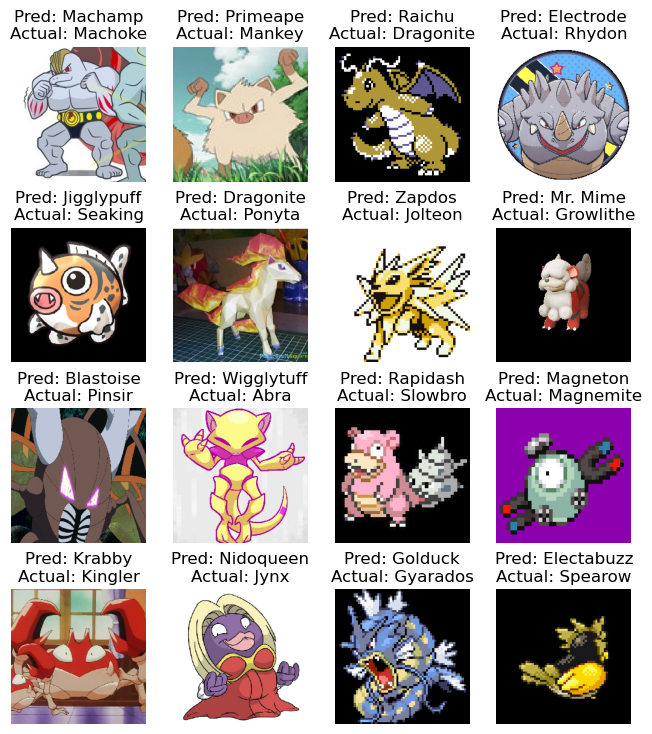

In [202]:
misclassified_image_idxs = [idx for idx, (pred, actual) in enumerate(zip(final_pred_labels, actual_labels)) if pred != actual]
misclassified_images = test_df.iloc[misclassified_image_idxs]
captions = [
    f'Pred: {class_names[final_pred_labels[idx]]}\nActual: {class_names[actual_labels[idx]]}'
    for idx in misclassified_image_idxs
]
display_images(misclassified_images['filename'][:16], captions[:16], (224, 224), 4, figsize=(8, 9))